In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import pickle
import math
import optuna
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn import preprocessing
from NFLUtils import NFLUtils
nfl_utils = NFLUtils()
from MLBUtils import MLBUtils
mlb_utils = MLBUtils()


import matplotlib.pyplot as plt
import numpy as np
import torch
from datetime import datetime, timedelta
import math
import torch.nn as nn
import requests as r
from bs4 import BeautifulSoup as bs
import umap
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Avoid truncating individual column values

## Global variables

[{'Season': 2024, 'Home_Team': 'PHI', 'Visitor_Team': 'WAS', 'Date': '2025-01-26'}, {'Season': 2024, 'Home_Team': 'KAN', 'Visitor_Team': 'BUF', 'Date': '2025-01-26'}]


In [2]:
current_season = 2025

In [3]:
def getAlternateAbbrv(teamName, isoDate, df):
    """
    This will return either 'None' (to signify & ignore double header) or the team name that matches 
    """
    alternateAbbrv = [
        ['CUB', 'CHN', 'CHC'],
        ['NYM', 'NYN'],
        ['STL', 'SLN'],
        ['SDG', 'SDN', 'SD'],
        ['KAN', 'KCA'],
        ['LAA', 'ANA'],
        ['LAD', 'LAN', 'LOS', 'LA'],
        ['WAS', 'WSH'],
        ['SFO', 'SFN', 'SF'],
        ['CWS', 'CHA'],
        ['TAM', 'TBA', 'TB'],
        ['NYY', 'NYA'],
        ['CHW', 'CHA'],
        ['KC', 'KCA'],
        ['OAK', 'ATH']
    ]
    isoDateTime = pd.to_datetime(isoDate).date()
    
    # Reduce to 1 dimension, check all alternate abbreviations
    alternateAbbrv = [item for subList in alternateAbbrv for item in subList if teamName in subList]
    alternateAbbrv.append(teamName)
    for teamAbbrv in alternateAbbrv:
        filtered_df = df[((df['Home_Team'] == teamAbbrv) | (df['Visitor_Team'] == teamAbbrv))]
        if len(filtered_df) > 0:
            return teamAbbrv
    print(f"WARNING: Cannot find team abbrv for {teamName}")
    return None

In [4]:
# Import newCombined
df = pd.read_csv("./baseballData/NewCombined.csv", index_col=False, low_memory=False)
print(f"Before season filter: {df.shape}")
df.columns = df.columns.str.replace(' ', '_')
# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")

# Filter for rows where the year is current_season
df = df[df['Date'].dt.year == current_season]
print(f"After season filter: {df.shape}")
df.head()

Before season filter: (33449, 129)
After season filter: (597, 129)


,Date,Home_Team,Home_Wins,Home_Losses,Visitor_Team,Visitor_Wins,Visitor_Losses,Final_Score,Visitor_Final_Score,Home_Final_Score,Winning_Team,Home/Victory_Win,Game_Time,Winning_Pitcher,Visiting_Pitcher,Winning_Pitcher_Team,Losing_Pitcher_Team,Game_Time_(Duration),Attendance,Field_Conditions,Temperature,Wind_Direction,Cloud_Coverage,HP_Umpire,1B_Umpire,2B_Umpire,3B_Umpire,LF_Umpire,RF_Umpire,V_AB,V_R,V_H,V_RBI,V_BB,V_SO,V_PA,V_BA,V_OBP,V_SLG,V_OPS,V_PIT,V_STR,V_WPA,V_aLI,V_WPA+,V_WPA-,V_cWPA,V_acLI,V_RE24,V_PO,V_A,V_Batting_Details,H_AB,H_R,H_H,H_RBI,H_BB,H_SO,H_PA,H_BA,H_OBP,H_SLG,H_OPS,H_PIT,H_STR,H_WPA,H_aLI,H_WPA+,H_WPA-,H_cWPA,H_acLI,H_RE24,H_PO,H_A,H_Batting_Details,V_IP,V_P_H,V_P_R,V_ER,V_P_BB,V_P_SO,V_HR,V_ERA,V_BF,V_PIT.1,V_STR.1,V_CTCT,V_STS,V_STL,V_GB,V_FB,V_LD,V_UNK,V_GSC,V_IR,V_IS,V_P_WPA,V_P_aLI,V_P_cWPA,V_P_acLI,V_P_RE24,H_IP,H_P_H,H_P_R,H_ER,H_P_BB,H_P_SO,H_HR,H_ERA,H_BF,H_PIT.1,H_STR.1,H_CTCT,H_STS,H_STL,H_GB,H_FB,H_LD,H_UNK,H_GSC,H_IR,H_IS,H_P_WPA,H_P_aLI,H_P_cWPA,H_P_acLI,H_P_RE24,H_start_odds,V_start_odds
32852,2025-05-06,ATL,17,18,CIN,18,19,1-2,1,2,ATL,H,7:15 p.m.,Raisel Iglesias,Lyon Richardson,ATL,CIN,3:07,"32,835",Unknown,77° F,6mph from Right to Left,Cloudy,Alex MacKay,Alan Porter,Brian Walsh,Chris Segal,NaN,NaN,37,1,7,1,3,17,41,0.189,0.268,0.216,0.485,168,113,-0.606,1.46,0.684,-1.291,-0.34%,1.35,-4.7,27,7,-,35,2,8,2,4,12,39,0.229,0.308,0.286,0.593,167,112,-0.106,2.00,1.276,-1.382,-0.05%,1.61,-2.2,30,7,-,9.0,8,2,1,4,12,0,1.00,39,167,112,63,19,30,11,12,6,0,67,2,0,0.106,2.00,0.06%,1.84,2.2,10.0,7,1,1,3,17,0,0.9,41,168,113,53,23,37,9,11,6,0,72,2,0,0.605,1.46,0.29%,1.18,4.7,1.444444,2.850000
32853,2025-05-06,BOS,18,19,TEX,18,18,6-1,6,1,TEX,V,6:45 p.m.,Nathan Eovaldi,Lucas Giolito,TEX,BOS,2:46,"29,858",Unknown,60° F,3mph out to Leftfield,Overcast,John Bacon,CB Bucknor,Adam Beck,Dan Iassogna,NaN,NaN,40,6,16,5,2,9,43,0.400,0.419,0.450,0.869,180,114,0.247,0.51,0.555,-0.306,0.14%,0.48,1.3,27,7,-,32,1,6,1,1,12,33,0.188,0.212,0.250,0.462,124,89,-0.252,0.46,0.091,-0.343,-0.16%,0.49,-3.7,27,7,-,9.0,6,1,1,1,12,0,1.00,33,124,89,54,21,14,7,13,8,0,64,0,0,0.251,0.46,0.14%,0.43,3.7,9.0,16,6,6,2,9,0,6.0,43,180,115,71,16,28,16,16,11,0,18,2,0,-0.248,0.51,-0.16%,0.55,-1.3,2.000000,1.833333
32854,2025-05-06,MIA,14,21,LAN,24,12,4-5,4,5,MIA,H,6:40 p.m.,JesÃºs Tinoco,J.P. Feyereisen,MIA,LAN,3:16,"17,312",NaN,72° F,0mph,In Dome,Erich Bacchus,Brian O'Nora,Mike Estabrook,Laz Diaz,NaN,NaN,35,4,8,4,5,11,40,0.229,0.325,0.486,0.811,178,115,-0.388,1.57,0.981,-1.368,-0.27%,1.80,-2.0,27,8,-,34,5,11,5,5,14,40,0.324,0.410,0.471,0.881,156,96,0.112,1.74,1.419,-1.308,0.03%,0.73,1.3,30,10,-,9.0,11,5,4,5,14,1,4.00,40,156,96,53,27,16,10,11,5,0,57,0,0,-0.112,1.74,-0.08%,2.00,-1.3,10.0,8,4,4,5,11,2,3.6,40,178,115,63,18,34,11,13,5,0,60,3,1,0.388,1.57,0.10%,0.66,2.0,3.200000,1.370370
32855,2025-05-06,MIL,19,18,HOU,17,18,3-4,3,4,MIL,H,6:40 p.m.,Chad Patrick,Hayden Wesneski,MIL,HOU,2:33,"21,075",Unknown,65° F,2mph from Left to Right,Sunny,John Tumpane,Chris Conroy,Brennan Miller,Jeremie Rehak,NaN,NaN,30,3,5,3,3,8,35,0.167,0.265,0.300,0.565,127,81,-0.359,1.04,0.429,-0.787,-0.21%,1.00,-1.6,24,6,-,29,4,6,4,4,10,34,0.207,0.303,0.414,0.717,150,95,0.142,0.56,0.440,-0.299,0.08%,0.50,-0.1,27,9,-,8.0,6,4,4,4,10,1,4.50,34,150,95,49,11,35,10,10,1,0,37,2,0,-0.141,0.56,-0.08%,0.54,0.1,9.0,5,3,3,3,8,1,3.0,35,127,81,51,9,21,11,12,4,0,59,2,0,0.361,1.04,0.19%,0.92,1.6,1.800000,2.050000
32856,2025-05-06,KCA,21,16,CHA,10,26,3-4,3,4,KCA,H,6:40 p.m.,Taylor Clarke,Cam Booser,KCA,CHA,2:26,"15,968",Unknown,74° F,8mph from Right to Left,Cloudy,John Libka,Sean Barber,James Hoye,D.J. Reyburn,NaN,NaN,36,3,10,2,3,5,39,0.278,0.333,0.278,0.611,134,84,-0.055,1.16,0.718,-0.776,-0.01%,0.28,-1.5,25,7,-,31,4,8,4,5,3,38,0.258,0.378,0.387,0.765,127,72,0.444,2.19,1.592,-1.146,0.30%,2.48,1.0,27,8,-,8.1,8,4,3,5,3,1,3.24,38,127,72,48,7,17,10,19,6,0,60,3,0,-0.445,2.19,-0.06%,0.53,-1.0,9.0,10,3,2,3,5,0,2.0,39,134,84,53,7,24,14,17,8,0,54,4,0,0.055,1.16,0.04%,1.31,1.5,1.444444,2.850000


In [5]:
# Retrieve games for current date
day_adjust_back = 0
iso_date_pre = (datetime.now() - timedelta(days=day_adjust_back)).replace(hour=0, minute=0, second=0, microsecond=0)
iso_date = iso_date_pre.strftime("%Y-%m-%d")

current_date_games = nfl_utils.getMLBOddsSharkData(iso_date)
current_date_games_filtered = []
print(iso_date_pre)
print(df.shape)
df = df[df['Date'] < iso_date_pre]
print(df.shape)
for game in current_date_games:
    # Home_Team & Visitor_Team must match
    game["Home_Team"] = getAlternateAbbrv(game["Home_Team"], game["Date"], df)
    game["Visitor_Team"] = getAlternateAbbrv(game["Visitor_Team"], game["Date"], df)
    if game["Home_Team"] is None or game["Visitor_Team"] is None:
        continue
    current_date_games_filtered.append(game)
    # FOR ONLINE
    game["H_start_odds"] = mlb_utils.americanToDecimal(game["Home_Odds"])
    game["V_start_odds"] = mlb_utils.americanToDecimal(game["Visitor_Odds"])
    # Offline
    # game["H_start_odds"] = mlb_utils.americanToDecimal(game["H_start_odds"])
    # game["V_start_odds"] = mlb_utils.americanToDecimal(game["V_start_odds"])
    del game["Home_Odds"]
    del game["Visitor_Odds"]
    print(game)
# current_date_games = pd.DataFrame.from_records(current_date_games)

https://www.oddsshark.com/api/scores/mlb/2025-05-13?_format=json
2025-05-13 00:00:00
(597, 129)
(597, 129)
{'Date': '2025-05-13', 'Rot': 972, 'Home_Team': 'CLE', 'Visitor_Team': 'MIL', 'H_start_odds': 1.7407407407407407, 'V_start_odds': 2.13}
{'Date': '2025-05-13', 'Rot': 974, 'Home_Team': 'CIN', 'Visitor_Team': 'CHA', 'H_start_odds': 1.4830917874396135, 'V_start_odds': 2.8600000000000003}
{'Date': '2025-05-13', 'Rot': 964, 'Home_Team': 'DET', 'Visitor_Team': 'BOS', 'H_start_odds': 1.8333333333333335, 'V_start_odds': 2.0}
{'Date': '2025-05-13', 'Rot': 966, 'Home_Team': 'TOR', 'Visitor_Team': 'TBA', 'H_start_odds': 1.7407407407407407, 'V_start_odds': 2.15}
{'Date': '2025-05-13', 'Rot': 954, 'Home_Team': 'NYN', 'Visitor_Team': 'PIT', 'H_start_odds': 1.4, 'V_start_odds': 3.05}
{'Date': '2025-05-13', 'Rot': 956, 'Home_Team': 'ATL', 'Visitor_Team': 'WAS', 'H_start_odds': 1.4545454545454546, 'V_start_odds': 2.8}
{'Date': '2025-05-13', 'Rot': 958, 'Home_Team': 'CHN', 'Visitor_Team': 'MIA', 'H

### Define cont_cols, y_col (taken from MLB_ANN)

In [6]:
current_date_games = pd.DataFrame(current_date_games, columns=df.columns)
current_date_games['Date'] = pd.to_datetime(current_date_games['Date'], format="%Y-%m-%d")
df = pd.concat([df, current_date_games], ignore_index=True)


# Replace spaces with underscores in column names
df.columns = df.columns.str.replace(' ', '_')

# Limit to first n rows
# df = df[:2000]
# Sort by date from least to greatest
df = df.sort_values(by='Date')

# Create the H_Won column
df['H_Won'] = np.where(df['Home_Final_Score'] > df['Visitor_Final_Score'], 1.0, 0.0)

# Create the H_final_allowed, V_final_allowed columns
df['H_Final_Allowed'] = df['Visitor_Final_Score']
df['V_Final_Allowed'] = df['Home_Final_Score']

df['H_Final_Score'] = df['Home_Final_Score']
df['V_Final_Score'] = df['Visitor_Final_Score']

df = df.sort_values(by='Date')



track_cols = [
    # General
    'Date',  # Date

    # Random
    'AB',
    'R',
    'H',
    'BB',
    'PA',
    
    
    # Batting stats
    'SO',    # Strikeouts
    'BA',    # Batting Average
    'OBP',   # On-Base Percentage
    'SLG',   # Slugging Percentage
    'OPS',   # On-Base Plus Slugging
    'RBI',   # Runs Batted In
    'PIT',   # Pitches
    'STR',   # Strikes
    'WPA',   # Win Probability Added
    'aLI',   # Average Leverage Index

    # Pitching stats
    'P_H',   # Hits Allowed by Pitcher
    'P_R',   # Runs Allowed by Pitcher
    'ER',    # Earned Runs by Pitcher
    'P_BB',  # Walks by Pitcher
    'P_SO',  # Strikeouts by Pitcher
    'HR',    # Home Runs Allowed by Pitcher
    'ERA',   # Earned Run Average
    'CTCT',  # Contact Rate
    'STS',   # Swings and Misses (Strikes)
    'STL',   # Stolen Bases Against
    'GB',    # Ground Balls
    'FB',    # Fly Balls
    'LD',    # Line Drives
    'GSC',   # Game Score
    'P_WPA', # Pitcher Win Probability Added
    'P_aLI',  # Pitcher Average Leverage Index

    # Odds 
    'start_odds',

    # Remove later
    'Final_Score',
    'Final_Allowed'
]


In [7]:
df.tail(15)
# print(df["Home_Team"].dtype)

,Date,Home_Team,Home_Wins,Home_Losses,Visitor_Team,Visitor_Wins,Visitor_Losses,Final_Score,Visitor_Final_Score,Home_Final_Score,Winning_Team,Home/Victory_Win,Game_Time,Winning_Pitcher,Visiting_Pitcher,Winning_Pitcher_Team,Losing_Pitcher_Team,Game_Time_(Duration),Attendance,Field_Conditions,Temperature,Wind_Direction,Cloud_Coverage,HP_Umpire,1B_Umpire,2B_Umpire,3B_Umpire,LF_Umpire,RF_Umpire,V_AB,V_R,V_H,V_RBI,V_BB,V_SO,V_PA,V_BA,V_OBP,V_SLG,V_OPS,V_PIT,V_STR,V_WPA,V_aLI,V_WPA+,V_WPA-,V_cWPA,V_acLI,V_RE24,V_PO,V_A,V_Batting_Details,H_AB,H_R,H_H,H_RBI,H_BB,H_SO,H_PA,H_BA,H_OBP,H_SLG,H_OPS,H_PIT,H_STR,H_WPA,H_aLI,H_WPA+,H_WPA-,H_cWPA,H_acLI,H_RE24,H_PO,H_A,H_Batting_Details,V_IP,V_P_H,V_P_R,V_ER,V_P_BB,V_P_SO,V_HR,V_ERA,V_BF,V_PIT.1,V_STR.1,V_CTCT,V_STS,V_STL,V_GB,V_FB,V_LD,V_UNK,V_GSC,V_IR,V_IS,V_P_WPA,V_P_aLI,V_P_cWPA,V_P_acLI,V_P_RE24,H_IP,H_P_H,H_P_R,H_ER,H_P_BB,H_P_SO,H_HR,H_ERA,H_BF,H_PIT.1,H_STR.1,H_CTCT,H_STS,H_STL,H_GB,H_FB,H_LD,H_UNK,H_GSC,H_IR,H_IS,H_P_WPA,H_P_aLI,H_P_cWPA,H_P_acLI,H_P_RE24,H_start_odds,V_start_odds,H_Won,H_Final_Allowed,V_Final_Allowed,H_Final_Score,V_Final_Score
592,2025-05-12,ATL,20.0,21.0,WAS,17.0,25.0,3-4,3.0,4.0,ATL,H,7:15 p.m.,Raisel Iglesias,Jackson Rutledge,ATL,WAS,2:21,"32,696",Unknown,76° F,7mph from Left to Right,Cloudy,Ben May,Austin Jones,Chad Fairchild,Bill Miller,NaN,NaN,33.0,3.0,8.0,2.0,2.0,8.0,36.0,0.242,0.306,0.394,0.699,132.0,81.0,-0.109,1.56,0.933,-1.041,-0.03%,0.76,-1.6,25,6.0,-,34.0,4.0,10.0,4.0,2.0,4.0,37.0,0.294,0.333,0.412,0.745,126.0,83.0,0.390,0.92,0.852,-0.460,0.18%,0.72,-0.1,27,12.0,-,8.1,10.0,4.0,4.0,2.0,4.0,1.0,4.32,37.0,126.0,83.0,50.0,9.0,24.0,13.0,18.0,7.0,0.0,45.0,2,1,-0.390,0.92,-0.11%,0.45,0.1,9.0,8.0,3.0,2.0,2.0,8.0,1.0,2.0,36.0,132.0,81.0,46.0,19.0,16.0,15.0,10.0,6.0,0.0,64.0,1,0,0.110,1.56,0.05%,1.22,1.6,1.526316,2.600000,1.0,3.0,4.0,4.0,3.0
593,2025-05-12,TEX,21.0,21.0,COL,7.0,34.0,1-2,1.0,2.0,TEX,H,7:05 p.m.,Tyler Mahle,Chase Dollander,TEX,COL,2:09,"23,123",Unknown,82° F,4mph out to Leftfield,Sunny,James Jean,Adam Hamari,Nestor Ceja,Todd Tichenor,NaN,NaN,31.0,1.0,6.0,1.0,3.0,7.0,34.0,0.194,0.265,0.226,0.491,121.0,75.0,-0.552,1.76,0.752,-1.306,-0.01%,0.03,-3.3,24,4.0,-,26.0,2.0,3.0,2.0,3.0,8.0,29.0,0.115,0.207,0.231,0.438,103.0,63.0,-0.052,0.99,0.544,-0.598,-0.03%,0.92,-1.8,27,9.0,-,8.0,3.0,2.0,2.0,3.0,8.0,1.0,2.25,29.0,103.0,63.0,37.0,9.0,17.0,6.0,12.0,4.0,0.0,66.0,0,0,0.052,0.99,0.00%,0.01,1.8,9.0,6.0,1.0,1.0,3.0,7.0,0.0,1.0,34.0,121.0,75.0,47.0,12.0,16.0,12.0,12.0,5.0,0.0,65.0,2,0,0.553,1.76,0.31%,1.63,3.3,1.377358,3.150000,1.0,1.0,2.0,2.0,1.0
608,2025-05-13,SFN,NaN,NaN,ARI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.952381,1.869565,0.0,NaN,NaN,NaN,NaN
597,2025-05-13,CLE,NaN,NaN,MIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.740741,2.130000,0.0,NaN,NaN,NaN,NaN
598,2025-05-13,CIN,NaN,NaN,CHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### 2. Get track dict, format to EMA

In [8]:
# Get track_dict
track_dict = {}

for row in df.itertuples():
    year = row.Date.year
    # year = row.Season
    home_team = row.Home_Team # Home Team
    visitor_team = row.Visitor_Team # Visitor team

    
    # Home or visitor team has < minimum_window total games
    for col in track_cols:
        home_column_name = f'{year}_{home_team}_{col}'
        visitor_column_name = f'{year}_{visitor_team}_{col}'
        
        # Home team
        home_col = col if col == 'Date' else 'H_' + col
        if home_column_name in track_dict:
            track_dict[home_column_name].append(getattr(row, home_col))
        else:
            track_dict[home_column_name] = [getattr(row, home_col)]
        
        # Visitor team
        visitor_col = col if col == 'Date' else 'V_' + col
        if visitor_column_name in track_dict:
            track_dict[visitor_column_name].append(getattr(row, visitor_col))
        else:
            track_dict[visitor_column_name] = [getattr(row, visitor_col)]


minimum_window = 4
ema_span = 7
print(df.shape)

show_examples = False

indices_to_drop = []
current_count = 0

for row in df.itertuples():
    if current_count % 300 == 0:
        print(f'{current_count}/{df.shape[0]}')
    current_count = current_count + 1
    index = row.Index
    year = row.Date.year
    # year = row.Season
    home_team = row.Home_Team
    visitor_team = row.Visitor_Team
    # Home team min window
    home_date_column = f'{year}_{home_team}_Date'
    visitor_date_column = f'{year}_{visitor_team}_Date'

    # Current row is older than Home team at min_window
    if row.Date <= track_dict[home_date_column][minimum_window]:
        indices_to_drop.append(index)
        continue
    # Current row is older than Visitor team at min_window
    if row.Date <= track_dict[visitor_date_column][minimum_window]:
        indices_to_drop.append(index)
        continue

    home_date_index = track_dict[home_date_column].index(row.Date)
    visitor_date_index = track_dict[visitor_date_column].index(row.Date)
    # print(f'H: {home_date_index} V: {visitor_date_index}')

    # print("----- Track Cols -----")
    # Update df to have average for each track_cols (Ignoring 'Date', the 1-2nd item)
    for col in track_cols:
        if col in ['Date', 'start_odds', 'halftime_odds', 'Final_Score', 'Final_Allowed']:
            continue
        else:
            # print(col)
            # Convert to float
            if df.dtypes['H_' + col] == 'int64' or df.dtypes['V_' + col] == 'int64':
                df = df.astype({f'H_{col}': 'float64', f'V_{col}': 'float64'})
            # Update df to have average for each track_cols (Ignoring 'Date', .. items)
            # Update home
            home_col_list = track_dict[f'{year}_{home_team}_{col}'][:home_date_index-1]
            dataframe_val = pd.DataFrame({'value': home_col_list})
            ema = dataframe_val['value'].ewm(span=min(ema_span, len(home_col_list)), adjust=True).mean().iloc[-1]
            df.at[index, 'H_' + col] = ema

            # Update Visitor
            visitor_col_list = track_dict[f'{year}_{visitor_team}_{col}'][:visitor_date_index-1]
            dataframe_val = pd.DataFrame({'value': visitor_col_list})
            ema = dataframe_val['value'].ewm(span=min(ema_span, len(visitor_col_list)), adjust=True).mean().iloc[-1]
            df.at[index, 'V_' + col] = ema


    # --------------------------------------------------- 
    # ------------------ Custom Columns -----------------
    # --------------------------------------------------- 
    #
    
    # 1. Add variant of Bill James pythagorean expectation (NFL).
    # Recent games weighted more heavily since 'Final' columns not excluded from the above loop
    home_points_for = sum(track_dict[f'{year}_{home_team}_Final_Score'][:home_date_index-1])
    home_points_against = sum(track_dict[f'{year}_{home_team}_Final_Allowed'][:home_date_index-1])
    df.at[index, 'H_pythagorean'] = home_points_for**1.83 / (home_points_for**1.83 + home_points_against**1.83)

    visitor_points_for = sum(track_dict[f'{year}_{visitor_team}_Final_Score'][:visitor_date_index-1])
    visitor_points_against = sum(track_dict[f'{year}_{visitor_team}_Final_Allowed'][:visitor_date_index-1])
    df.at[index, 'V_pythagorean'] = visitor_points_for**1.83 / (visitor_points_for**1.83 + visitor_points_against**1.83)

df.drop(indices_to_drop, inplace=True)
df.to_csv(f'./baseballData/PREDICTVERSIONCombinedSlidingWindow{minimum_window}.csv')

# Add custom metrics to track_cols so it creates the difference (D_) column
track_cols.append('pythagorean')
for col in track_cols[1:]:
    # cont_cols.append('D_' + col) This is unnecessary? 5/3/25
    if col == 'fstart_odds':
        print(col)
        print(f"{df['H_' + col]} col  {col}")
        print(col)
        print(f"{df['V_' + col]} col  {col}")
    df['D_' + col] = (df['H_' + col] - df['V_' + col]).round(3) # Round to 3 sig figs

df['D_start_odds']
# Remove columns that begin with H_ or V_ in df
y_col = ['H_Won', 'H_start_odds', 'V_start_odds']
df = df.loc[:, ~(df.columns.str.startswith(('H_', 'V_')) & (~df.columns.isin(y_col)))]

print(df.shape)

(610, 134)
0/610
300/610
600/610
(530, 67)


In [9]:
# -- The following contains old debug code --
# df
# track_dict["2025_CIN_start_odds"]
# df.to_csv(f'./baseballData/PREDICTVERSIONCombinedSlidingWindow{minimum_window}.csv')
df.tail()

,Date,Home_Team,Home_Wins,Home_Losses,Visitor_Team,Visitor_Wins,Visitor_Losses,Final_Score,Visitor_Final_Score,Home_Final_Score,Winning_Team,Home/Victory_Win,Game_Time,Winning_Pitcher,Visiting_Pitcher,Winning_Pitcher_Team,Losing_Pitcher_Team,Game_Time_(Duration),Attendance,Field_Conditions,Temperature,Wind_Direction,Cloud_Coverage,HP_Umpire,1B_Umpire,2B_Umpire,3B_Umpire,LF_Umpire,RF_Umpire,H_start_odds,V_start_odds,H_Won,D_AB,D_R,D_H,D_BB,D_PA,D_SO,D_BA,D_OBP,D_SLG,D_OPS,D_RBI,D_PIT,D_STR,D_WPA,D_aLI,D_P_H,D_P_R,D_ER,D_P_BB,D_P_SO,D_HR,D_ERA,D_CTCT,D_STS,D_STL,D_GB,D_FB,D_LD,D_GSC,D_P_WPA,D_P_aLI,D_start_odds,D_Final_Score,D_Final_Allowed,D_pythagorean
606,2025-05-13,SDN,NaN,NaN,ANA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.454545,2.800000,0.0,5.464,4.370,4.498,0.116,6.033,-3.664,0.068,0.059,0.056,0.114,4.101,11.637,8.253,0.066,-0.101,-0.490,0.018,0.354,-1.002,-0.879,0.235,0.702,-8.472,-2.115,-2.784,-1.810,1.277,-0.227,2.685,0.099,-0.168,-1.345,NaN,NaN,0.302
607,2025-05-13,SEA,NaN,NaN,NYA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.220000,1.689655,0.0,-2.782,-4.462,-2.834,-1.859,-6.054,-0.190,-0.058,-0.089,-0.189,-0.279,-4.250,-19.308,-8.328,-0.212,0.125,2.447,1.773,1.712,0.706,-1.423,0.067,1.470,10.470,-3.456,3.588,0.501,3.518,3.007,-17.395,-0.108,0.128,0.530,NaN,NaN,-0.105
602,2025-05-13,ATL,NaN,NaN,WAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.454545,2.800000,0.0,1.462,0.337,-0.296,0.459,1.866,-0.566,-0.012,-0.001,-0.019,-0.021,0.211,13.637,9.985,-0.137,0.368,-0.970,-2.847,-2.919,-1.118,1.848,-0.361,-3.015,-4.790,2.455,1.946,0.635,-2.072,-1.552,10.372,0.403,0.649,-1.345,NaN,NaN,0.110
600,2025-05-13,TOR,NaN,NaN,TBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.740741,2.150000,0.0,3.353,1.874,2.918,0.001,3.507,-0.265,0.070,0.054,0.124,0.178,2.123,5.246,5.754,0.225,-0.108,0.306,-0.042,0.097,-0.313,3.880,0.046,0.275,-7.164,5.313,0.248,-2.850,-0.974,-1.030,-2.478,-0.129,-0.050,-0.409,NaN,NaN,-0.030
609,2025-05-13,LAN,NaN,NaN,ATH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500000,2.650000,0.0,-0.821,0.327,-0.658,1.055,0.395,-0.194,-0.018,-0.002,-0.023,-0.026,0.114,9.726,2.532,-0.114,0.038,-0.755,-1.517,-1.431,-1.292,-0.623,-0.067,-1.199,-5.351,-2.706,-5.683,2.820,-5.388,-2.925,-3.137,0.090,-0.358,-1.150,NaN,NaN,0.179


### 3. Create an array of continuous values
Numpy array 'conts' containing stack of each continuous column

In [10]:

cont_cols = [
    # General
    
    # Random
    'D_AB',
    'D_R',
    'D_H',
    'D_BB',
    'D_PA',
    
    # Batting stats
    'D_SO',    # Strikeouts
    'D_BA',    # Batting Average
    'D_OBP',   # On-Base Percentage
    'D_SLG',   # Slugging Percentage
    'D_OPS',   # On-Base Plus Slugging
    'D_RBI',   # Runs Batted In
    'D_PIT',   # Pitches
    'D_STR',   # Strikes
    'D_WPA',   # Win Probability Added
    'D_aLI',   # Average Leverage Index

    # Pitching stats
    'D_P_H',   # Hits Allowed by Pitcher
    'D_P_R',   # Runs Allowed by Pitcher
    'D_ER',    # Earned Runs by Pitcher
    'D_P_BB',  # Walks by Pitcher
    'D_P_SO',  # Strikeouts by Pitcher
    'D_HR',    # Home Runs Allowed by Pitcher
    'D_ERA',   # Earned Run Average
    'D_CTCT',  # Contact Rate
    'D_STS',   # Swings and Misses (Strikes)
    'D_STL',   # Stolen Bases Against
    'D_GB',    # Ground Balls
    'D_FB',    # Fly Balls
    'D_LD',    # Line Drives
    'D_GSC',   # Game Score
    'D_P_WPA', # Pitcher Win Probability Added
    'D_P_aLI', # Pitcher Average Leverage Index

    # Odds
    'D_start_odds',

    # Calculated
    'D_pythagorean',
    
    # Remove later
    # 'D_Final_Score',
    # 'D_Final_Allowed'
]



df['Home_Team'] = df['Home_Team'].astype('category')
df['Visitor_Team'] = df['Visitor_Team'].astype('category')
df['Home_Team_Id'] = df['Home_Team'].cat.codes
df['Visitor_Team_Id'] = df['Visitor_Team'].cat.codes

# Retrieve original team name given a category code
home_cat_mapping = df['Home_Team'].cat.categories
home_team_from_id = lambda cat_code: home_cat_mapping[cat_code]
visitor_cat_mapping = df['Visitor_Team'].cat.categories
visitor_team_from_id = lambda cat_code: visitor_cat_mapping[cat_code]



drop_cols = [ 'D_BA', 'D_datediff', 'D_AB', 'D_P_WPA', 'D_P_H', 'D_ER', 'D_BA', 'D_ERA', 'D_SLG', 'D_H', 'D_STR' ]
y_col = ['H_Won', 'H_start_odds', 'V_start_odds', 'Home_Team_Id', 'Visitor_Team_Id']

cont_cols = [col for col in cont_cols if col not in drop_cols]

# Create cont_df and y_df from the filtered df
cont_df = df[cont_cols]

# Normalize cont_df
with open('MLB_scaler.pkl', 'rb') as f:
    standard_scaler = pickle.load(f)
cont_scaled = standard_scaler.transform(cont_df.values)
cont_df = pd.DataFrame(cont_scaled)

y_df = df[y_col]
y_df_team = df[['Date', 'Home_Team', 'Visitor_Team']]
y_df_team['Date'] = y_df_team['Date'].dt.strftime('%Y-%m-%d')

# Retrieve original team name given a category code
home_cat_mapping = df['Home_Team'].cat.categories
home_team_from_id = lambda cat_code: home_cat_mapping[cat_code]
visitor_cat_mapping = df['Visitor_Team'].cat.categories
visitor_team_from_id = lambda cat_code: visitor_cat_mapping[cat_code]


/var/folders/k0/7b4qgkdx2vb9ml4ktdckf0hc0000gn/T/ipykernel_13443/1179606068.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df_team['Date'] = y_df_team['Date'].dt.strftime('%Y-%m-%d')


In [11]:
# test_sample = np.ones((2, 24))  # A single row with 24 features, all set to 1
# print(standard_scaler.transform(test_sample))

In [12]:
# df.tail(15)

In [13]:
conts = np.stack([cont_df[col].values for col in list(cont_df.columns)], 1)
y_col = np.stack([y_df[col].values for col in list(y_df.columns)], 1)


y_col_team = np.stack([y_df_team[col].values for col in list(y_df_team.columns)], 1)


print(conts.shape)
print(y_col.shape)

(530, 24)
(530, 5)


In [14]:
# conts[-15:,:]
# cont_df.tail()
print(type(conts))

<class 'numpy.ndarray'>


### 4. Get only the current date games, load model, make prediction

In [15]:
conts_current_date = conts[len(conts) - len(current_date_games):]
y_col_current_date = y_col[len(conts) - len(current_date_games):]
#y_col_current_date_teams = y_col_team[len(conts) - len(current_date_games):]

print(conts_current_date.shape)
print(type(conts_current_date))

# conts_current_date = torch.tensor(conts_current_date, dtype=torch.float32)
# y_col_current_date = torch.tensor(y_col_current_date, dtype=torch.float32)
conts_current_date = torch.FloatTensor(conts_current_date)
y_col_current_date = torch.FloatTensor(y_col_current_date)

print(type(conts_current_date))

(13, 24)
<class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [16]:
# y_col_current_date_teams

In [17]:
class TabularModelUpdated(nn.Module, BaseEstimator, RegressorMixin):
    def __init__(self, n_cont, out_sz, layer_shape, p=0.5, optimizer_class=torch.optim.Adam,
                 lr=0.001, confidence_threshold=0.1, batch_size=1000):
        super().__init__()
        # Model architecture params
        self.layer_shape = layer_shape
        self.batch_size = batch_size
        self.n_cont = n_cont
        self.out_sz = out_sz
        self.p = p
        self.lr = lr

        # Training params
        # self.criterion = criterion
        self.confidence_threshold = confidence_threshold
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Variable that holds the list of layers
        layerlist = []
        n_in = n_cont # no embed again
        # Iterate through the passed in "layers" parameter (ie, [200,100]) to build a list of layers
        for i, width in enumerate(self.layer_shape):
            # First layer gets special treatment
            if i == 0:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.Mish(),  # Mish instead of ReLU
                    nn.BatchNorm1d(width),
                    nn.Dropout(p/2)  # Less dropout in earlier layers
                ])
            else:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.Mish(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p)
                ])
            n_in = width
        # layerlist.append(nn.Linear(layers[-1], out_sz))
        
        # Final layer
        layerlist.extend([nn.Linear(self.layer_shape[-1], out_sz)])
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist).to(self.device)
        
        # Initialize the optimizer & scheduler
        self.optimizer = optimizer_class(self.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min',
                                                                    factor=0.1, patience=10,
                                                                    threshold=0.0001,threshold_mode='rel',
                                                                    cooldown=0, min_lr=0, eps=1e-08)
        
    def forward(self, x_cont):
        # x_cont = self.bn_cont(x_cont)  # Normalize the incoming continuous data
        x = self.layers(x_cont)        # Set up model layers
        return torch.clamp(x, -1, 1)
    
    def fit(self, X, y):
        """
        For sklearn pipeline
        """
        # Convert X,y to torch.tensor if needed
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X).to(self.device)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y).to(self.device)
        
        # Initialize optimizer
        # optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        # Verify optimizer exists
        if not hasattr(self, 'optimizer'):
            raise ValueError("Optimizer not initialized. Set self.optimizer in __init__.")

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        # Training loop
        running_loss = []    # This is only for training over final dataset
        self.train()
        for X_batch, y_batch in dataloader:
            self.optimizer.zero_grad()
            y_pred = self.forward(X_batch)[:,0]
            #loss = self.criterion(y_pred, y_batch)
            loss = mlb_utils.custom_criterion(y_pred, y_batch)
            running_loss.append(loss)
            loss.backward()
            self.optimizer.step()
        # return self  # TODO: This being replaced w/ loss might break things
        return torch.mean(torch.stack(running_loss))

    def step_lr(self, val_loss):
        """
        Since CV is run outside of this class, we need to update the local self.optimizer variable
        after each CV fold.
        """
        self.scheduler.step(val_loss)
    
    def predict(self, X):
        self.eval()
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X).to(self.device)
        with torch.no_grad():
            y_pred = self(X).squeeze()
        return y_pred
        
    def score(self, X, y):
        """
        12/5 - this isn't called at all if 'scoring' is defined
        """
        self.eval()
    
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)
    
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
    
        total_loss = 0.0
        count = 0
    
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                y_pred = self.forward(X_batch)[:, 0]  # [batch_size]
                batch_loss = mlb_utils.custom_criterion(y_pred, y_batch)  # scalar
                total_loss += batch_loss.item() * len(X_batch)
                count += len(X_batch)
    
        return total_loss / count

### Make predicitons

In [18]:
# conts_current_date = torch.FloatTensor(conts_current_date)

# Model class must be defined somewhere
# model = torch.load("MLB_Model.pt", weights_only=False)
# model.eval()
# x = model.predict(conts_current_date)

In [19]:
#conts_current_date

In [20]:
conts_current_date = torch.FloatTensor(conts_current_date)

# Model class must be defined somewhere
model = torch.load("MLB_Model.pt", weights_only=False)
model.eval()
x = model.predict(conts_current_date)

preds = x
max_bet_pct = 0.1

# Part of the loss function (cant call it directly since it expects h_won for y col)
h_start_odds = y_col_current_date[:,1]
v_start_odds = y_col_current_date[:,2]

y_decimal_odds = torch.where(x > 0, h_start_odds, v_start_odds) # Decimal odds for model's predicted outcome
x = torch.where(x > 0, (x + 1) / 2, (1 - x) / 2)
kelly_criterion = x - ((1 - x) / (y_decimal_odds - 1))
bet_multiplier = torch.clamp(kelly_criterion, min=0)   # Kelly results that are negative are ignored
bet_multiplier_numpy = bet_multiplier.numpy()
print(f"num bets {bet_multiplier_numpy.shape[0]}")
max_bet_pct = min((1.0 / bet_multiplier_numpy.shape[0]), 0.08)
bet_multiplier = bet_multiplier*max_bet_pct            # Scale down the bets to the maximum allowed percentage per bet


print(f"Date: {iso_date}")

for i in range(bet_multiplier_numpy.shape[0]):
    # pred_team = 0 if preds[i] > 0 else 1
    # other_team = abs(pred_team - 1)
    #print(home_team_from_id(int(y_col_current_date[i][3])))
    #print(visitor_team_from_id(int(y_col_current_date[i][4])))
    pred_team = 3 if preds[i] > 0 else 4
    other_team = 3 if pred_team == 4 else 4
    pred_team = home_team_from_id(int(y_col_current_date[i][pred_team])) # mlb_utils.get_team_name(y_col_current_date_teams[i][pred_team])
    other_team = visitor_team_from_id(int(y_col_current_date[i][other_team])) # mlb_utils.get_team_name(y_col_current_date_teams[i][other_team])
    # print(f"{bet_multiplier_numpy[i]} \n\tfor {pred_team} \n\tagainst {other_team}\n\todds {y_decimal_odds[i]}")
    print(f"{bet_multiplier[i]:.{4}},\t{mlb_utils.get_team_name(pred_team)}\t\t{mlb_utils.get_team_name(other_team)},{y_decimal_odds[i]:.{6}}")


num bets 13
Date: 2025-05-13
0.07692,	San Francisco Giants		Arizona Diamondbacks,1.95238
0.07692,	Cleveland Guardians		Milwaukee Brewers,1.74074
0.07692,	Cincinnati Reds		Chicago White Sox,1.48309
0.07692,	Detroit Tigers		Boston Red Sox,1.83333
0.07692,	New York Mets		Pittsburgh Pirates,1.4
0.07692,	Texas Rangers		Colorado Rockies,1.43478
0.07692,	Chicago Cubs		Miami Marlins,1.37736
0.07692,	Houston Astros		Kansas City Royals,1.71429
0.07692,	San Diego Padres		Los Angeles Angels,1.45455
0.07692,	Seattle Mariners		New York Yankees,2.22
0.07692,	Atlanta Braves		Washington Nationals,1.45455
0.07692,	Tampa Bay Rays		Toronto Blue Jays,2.15
0.07692,	Los Angeles Dodgers		Athletics,1.5


https://www.espn.com/mlb/scoreboard/_/date/20250503

## Backtest previous dates

In [21]:
y_col_team

array([['2025-04-01', 'LAN', 'ATL'],
       ['2025-04-02', 'SEA', 'DET'],
       ['2025-04-02', 'HOU', 'SFN'],
       ...,
       ['2025-05-13', 'ATL', 'WAS'],
       ['2025-05-13', 'TOR', 'TBA'],
       ['2025-05-13', 'LAN', 'ATH']], dtype=object)

[1.0727273 1.08      0.92      0.92      0.92      0.92      1.0761905
 1.0347826 1.0695652 0.92      1.0761905 1.092     0.92      0.92
 1.0592593 1.054054  1.0679399 0.92      1.08      1.096     1.144
 0.92      1.0533333 0.92      1.092     0.92      0.92      1.0490798
 0.92      1.05      1.0484848 1.0761905 0.92      0.92      0.92
 0.92      1.0285714 0.92      0.92      1.0421053 1.0301887 0.92
 0.92      0.92      0.92      0.92      0.92      0.92      0.92
 0.92      0.92      0.92      1.092     0.92     ]
2025-05-10 - Pred: Minnesota Twins won against San Francisco Giants. Correct: True 479.5091131925583 
2025-05-10 - Pred: Arizona Diamondbacks won against Los Angeles Dodgers. Correct: True 517.8698628262616 
2025-05-10 - Pred: Milwaukee Brewers won against Tampa Bay Rays. Correct: False 476.4402824430465 
2025-05-10 - Pred: New York Yankees won against Athletics. Correct: False 438.3250677990578 
2025-05-10 - Pred: Baltimore Orioles won against Los Angeles Angels. Correc

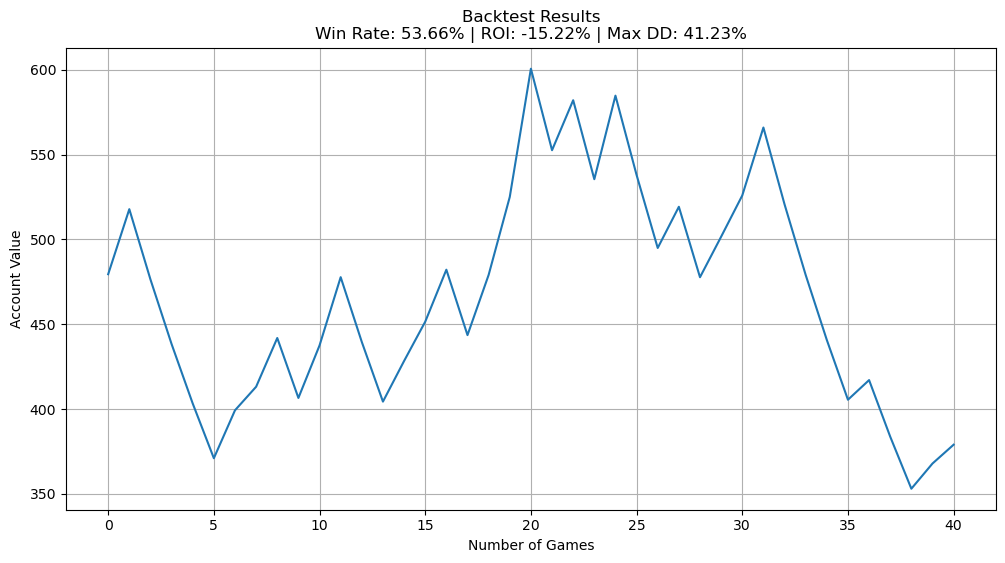

{'final_value': 378.98278074008294,
 'roi': -0.15216380147632452,
 'win_rate': 0.5365853658536586,
 'max_drawdown': 0.41232374589405124,
 'total_bets': 41}

In [22]:
num_trailing_bets = 54
end_idx = len(conts)#  - len(current_date_games)
start_idx = end_idx - num_trailing_bets
backtest_conts = conts[start_idx:end_idx]
backtest_y_col = y_col[start_idx:end_idx]
backtest_y_col_tensor = torch.FloatTensor(backtest_y_col)
backtest_y_col_team = y_col_team[start_idx:end_idx]


# Home team ID
home_teams = [mlb_utils.get_team_name(home_cat_mapping[int(idx.item())]) for idx in backtest_y_col[:,3]]
visitor_teams = [mlb_utils.get_team_name(visitor_cat_mapping[int(idx.item())]) for idx in backtest_y_col[:,4]]


backtest_preds = model.predict(backtest_conts)
performance_tensor = mlb_utils.custom_criterion(backtest_preds, backtest_y_col_tensor, 0.5, 0.08, True).numpy()
print(performance_tensor)
mlb_utils.backtest_model_custom_loss(performance_tensor, backtest_y_col_team, initial_capital=447, show_plot=True,
                                     home_teams=home_teams, visitor_teams=visitor_teams, probas=backtest_preds)
# print(y_col_current_date)

### Random debug notes

In [23]:

data = [ [-1.69191174, -0.69818685, -0.72334979,  0.78798276, -0.32290366,
        -1.00123061, -1.81875709, -0.1817851 , -0.55377829,  0.25402984,
         1.24671704,  0.00590094, -1.18930253,  2.10791275, -0.01988866,
        -0.68534643, -0.04055343,  0.77783622,  0.18465391,  0.24224438,
        -0.57523119, -1.6716547 ,  0.06119848, -1.89523723]]


data = [[-1.6919, -0.6982, -0.7233,  0.7880, -0.3229, -1.0012, -1.8188, -0.1818,
         -0.5538,  0.2540,  1.2467,  0.0059, -1.1893,  2.1079, -0.0199, -0.6853,
         -0.0406,  0.7778,  0.1847,  0.2422, -0.5752, -1.6717,  0.0612, -1.8952]]


tensor = torch.FloatTensor(data)

print(model.predict(tensor))

tensor(1.)
